# Libraries

In [1]:
import pickle
import nltk
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

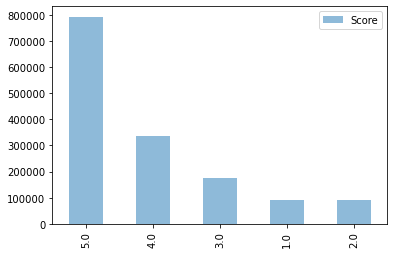


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [7]:
stop_words = set(stopwords.words('english'))

# # Function to remove stop words
def remove_stop_words(text):
    if pd.isna(text):  # Check for NaN values
        return 'n/a'  # Return 'n/a' for missing text
    words = word_tokenize(text)  # Tokenize the text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stop words
    return ' '.join(filtered_words)

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Review (Text) Length'] = df['Text'].str.len()
    df['Review (Text) Length'] = df['Text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

    # cleaning up the text and summary fields
    # Process the 'Summary' column
    df['Short Summary'] = df['Summary'].str.lower()
    df['Short Summary'] = df['Short Summary'].str.replace(f'[{string.punctuation}]', '', regex=True)
    df['Short Summary'] = df['Short Summary'].apply(remove_stop_words)
    df['Short Summary'] = df['Short Summary'].fillna('')

    # # Process the 'Text' column
    df['Short Text'] = df['Text'].str.lower()
    df['Short Text'] = df['Short Text'].str.replace(f'[{string.punctuation}]', '', regex=True)
    df['Short Text'] = df['Short Text'].apply(remove_stop_words)
    df['Short Text'] = df['Short Text'].fillna('')

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [8]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [9]:
# features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'Review (Text) Length']

features = ['Short Summary', 'Short Text']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [10]:
# Learn the model
#model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Prepare text features
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['Short Text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['Short Text'])
X_submission_tfidf = tfidf_vectorizer.transform(X_submission['Short Text'])

# Apply LSA using TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=0)  # Choose number of components
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_test_lsa = svd.transform(X_test_tfidf)
X_submission_lsa = svd.transform(X_submission_tfidf)

# Train a classifier (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_lsa, Y_train)

# Predict the score using the model
# Y_test_predictions = model.predict(X_test_select)
Y_test_predictions = model.predict(X_test_lsa)

# Model Evaluation

Accuracy on testing set =  0.5790443156602108


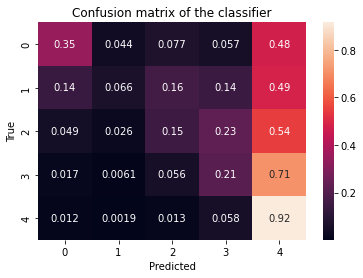

In [11]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [13]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_lsa)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)